In [1]:
import helper

data_dir = './data'
# Let's download the dataset
#helper.download_celeb_a()

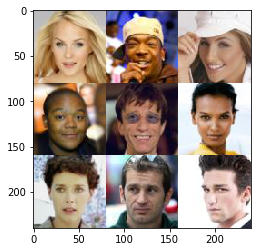

In [2]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np
import random

# Image configuration
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
data_files = glob(os.path.join(data_dir, 'out_64/*.jpg'))
attrib_files=glob(os.path.join(data_dir, 'attributes/*.txt'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3



def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)


    return np.array(image.convert(mode))

def get_attrib(attrib_path):
    file=open(attrib_path,"rt")
    attributes=list(map(int,file.readline().split()))
    file.close()
    return attributes

def get_batch(image_files,attrib_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)
    attrib_batch=np.array(
        [get_attrib(attrib_file) for attrib_file in attrib_files]).astype(np.float32)
    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch,attrib_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch,attrib_batch = get_batch(
            data_files[current_index:current_index + batch_size],attrib_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5,attrib_batch
        

test_images,attribs = get_batch(glob(os.path.join(data_dir, 'out/*.jpg'))[:10],glob(os.path.join(data_dir, 'attributes/*.txt'))[:10], 56, 56)
pyplot.imshow(helper.images_square_grid(test_images))

In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
from tensorflow.python.tools import inspect_checkpoint as chkp

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    attribs=tf.placeholder(tf.float32, (None, 40), name='input_z')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return attribs,inputs_real, inputs_z, learning_rate

In [4]:
def discriminator(images,attribs, reuse=False,is_training=True):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        x = tf.layers.conv2d(images, 64, 4, 2, 'SAME')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.maximum(alpha * x, x)
        
        # Conv 2
        x = tf.layers.conv2d(x, 128, 4, 2, 'SAME')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.maximum(alpha *x, x)
        
        # Conv 3
        x = tf.layers.conv2d(x, 256, 4, 2, 'SAME')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 512, 4, 2, 'SAME')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x)
        # Flatten
        flat = tf.reshape(x, (-1, 4*4*512))
        # Logits
        con=tf.layers.dense(flat,512)
        con = tf.maximum(alpha * con, con)
        
        att=tf.layers.dense(attribs,128)
        att = tf.maximum(alpha * att, att)
        
        con=tf.concat([con,att],1)
        con = tf.maximum(alpha * con, con)
        con=tf.layers.dense(con,128)
        con = tf.maximum(alpha * con, con)
        logits = tf.layers.dense(con, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

In [5]:
def generator(epsilon,attribs, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(attribs, 128)
        lrelu_x = tf.maximum(alpha * x_1, x_1)
        z_1=tf.layers.dense(attribs, 128)
        lrelu_z = tf.maximum(alpha * z_1, z_1)
        
        
        con=lrelu_z+tf.keras.backend.exp(lrelu_x/2)*epsilon
        con_1=tf.layers.dense(con,128 * 4 * 4 * 4)
        con_relu = tf.maximum(alpha * con_1,con_1)
        
        
        
        
        # Reshape it to start the convolutional stack
        x = tf.reshape(con_relu, (-1, 4, 4, 128*4))
        # Deconv 1
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x, 256, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 256, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x, 128, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
        # Deconv 2
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x,64, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x, 32, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # Output layer
        logits = tf.layers.conv2d(x, out_channel_dim, 4, 1, padding='SAME')
        out = tf.tanh(logits)
        return out

In [6]:
def model_loss(input_real, input_z,attribs, out_channel_dim,batch_size):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z,attribs, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real,attribs)
    d_model_wrong, d_logits_wrong = discriminator(input_real[:batch_size-1],attribs[1:],reuse=True)
    d_model_fake, d_logits_fake = discriminator(g_model,attribs, reuse=True)
    
    #d_loss= 0.5*(-tf.reduce_mean(d_logits_real)+0.5*(tf.reduce_mean(d_logits_fake)+tf.reduce_mean(d_logits_wrong)))
    
    #g_loss= -tf.reduce_mean(d_logits_fake)
    
    #lam=10
    
    #eps=tf.random_uniform([batch_size,1,1,1],minval=0.0,maxval=1.0)
    #x_h=eps*input_real+(1-eps)*g_model
    
    #with tf.variable_scope('', reuse=True) as scope:
        #grad_d_x_h=tf.gradients(discriminator(x_h,attribs,reuse=True,is_training=False),x_h)
    
    #grad_norm=tf.norm(grad_d_x_h[0],axis=1,ord='euclidean')
    #grad_pen=tf.reduce_mean(tf.square(grad_norm-1))
    
    #d_loss+=lam*grad_pen
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss_wrong = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_wrong,labels=tf.zeros_like(d_model_wrong)))
    
    d_loss = 0.5*(d_loss_real + 0.5*(d_loss_fake+d_loss_wrong))
                                                  
    g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake) * label_smoothing))
    g_loss=g_loss_fake
    
    
    return d_loss, g_loss

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [8]:
def show_generator_output(sess, n_images, input_z, attribs ,batch_images,batch_attribs ,out_channel_dim,batch_size):
    """
    Show example output for the generator
    """
    
    
    f=open("/Studies/GANs/dcgan-oreilly/data/CelebAMask-HQ-attribute-anno.txt","rt")
    no_of_images=int(f.readline())
    attribute_names=list(f.readline().split())
    names=[]
    rand_no=random.randint(0,batch_size-1)
    example_attribs=batch_attribs[rand_no]
    example_img=batch_images[rand_no]
    example_attribs=np.reshape(example_attribs,(1,40))
    example_img=np.reshape(example_img,(1,64,64,3))
    for n in range(40):
        if example_attribs[0,n]==1:
            names.append(attribute_names[n])

    
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.normal(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z,attribs,out_channel_dim, False),
        feed_dict={input_z: example_z, attribs:example_attribs})
    print(names)
    pyplot.imshow(helper.images_square_grid(example_img))
    pyplot.show()
    pyplot.imshow(helper.images_square_grid(samples))
    pyplot.show()

In [9]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    attribs,input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,attribs, data_shape[3],batch_size)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    steps = 0
    with tf.Session(config=config) as sess:

        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images ,batch_attribs in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.normal(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, attribs:batch_attribs})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, attribs:batch_attribs})
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images,attribs:batch_attribs})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images,attribs:batch_attribs})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    _ = show_generator_output(sess, 1, input_z,attribs, batch_images,batch_attribs,data_shape[3],batch_size)
                    
            save_path = saver.save(sess, "/save_64_new/model.ckpt")
            print("Model saved in path: %s" % save_path)

In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5
epochs = 150
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
